<a href="https://colab.research.google.com/github/afiflh/Machine_Learning/blob/main/modul10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Jobsheet 10: Recurrent Neural Network (RNN)

Nama : Afif Lukmanul Hakim

Kelas : TI-3G/02

NIM : 2141720262

**Praktikum 1**

In [3]:
# Setup

import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

In [4]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])

In [5]:
# Setup input pipeline

dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])


Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.
text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0
texts:  [b'Little Edie and Big Edie are characters that anyone can feel compassion for. Even though their house was filthy, th

In [7]:
# Buat Teks Encoder

VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [8]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

In [10]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[111,   1,   3, ...,   0,   0,   0],
       [ 11,  14,  85, ...,   0,   0,   0],
       [ 10, 232,  73, ...,   0,   0,   0]])

In [11]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b'Little Edie and Big Edie are characters that anyone can feel compassion for. Even though their house was filthy, this is somehow understandable considering their mental illness. On the message board a poster wrote that "Little Edie has the coping skills of an eight year old." This reminded me of when in the dramatized 2009 version, Big Edie says to Little Edie, "If you\'re stuck, it\'s only with yourself!" These women had everything; beauty, talent, intelligence, firm belief in their opinions and actions. Perhaps if Little Edie wasn\'t so hard on herself the first time things didn\'t work out, losing her hair, her job, and the love of her life, she would have made it. This somehow ties into what I believe is her mental illness: her inability to pick herself up when times are hard and see that good times lie ahead. The world will never know what have happened if she didn\'t listen to her mom\'s plea, "Come home, Edie! Let me take care of you!"<br /><br />Yet these understan

In [12]:
# Buat Model

model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [14]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


In [15]:
# predict on a sample text without padding.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 9s 9s/step
[0.00338426]


In [16]:
# predict on a sample text with padding

padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

1/1 [==============================] - 0s 62ms/step
[0.00338426]


In [17]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [18]:
# Train Model

history = model.fit(train_dataset, epochs=10,
          validation_data=test_dataset,
          validation_steps=30)

Epoch 1/10
391/391 [==============================] - 49s 100ms/step - loss: 0.6270 - accuracy: 0.5741 - val_loss: 0.4974 - val_accuracy: 0.7953
Epoch 2/10
391/391 [==============================] - 27s 69ms/step - loss: 0.4435 - accuracy: 0.7875 - val_loss: 0.4053 - val_accuracy: 0.8177
Epoch 3/10
391/391 [==============================] - 26s 65ms/step - loss: 0.3715 - accuracy: 0.8351 - val_loss: 0.3672 - val_accuracy: 0.8422
Epoch 4/10
391/391 [==============================] - 24s 62ms/step - loss: 0.3411 - accuracy: 0.8518 - val_loss: 0.3479 - val_accuracy: 0.8526
Epoch 5/10
391/391 [==============================] - 26s 65ms/step - loss: 0.3290 - accuracy: 0.8590 - val_loss: 0.3354 - val_accuracy: 0.8568
Epoch 6/10
391/391 [==============================] - 26s 65ms/step - loss: 0.3143 - accuracy: 0.8662 - val_loss: 0.3298 - val_accuracy: 0.8500
Epoch 7/10
391/391 [==============================] - 25s 64ms/step - loss: 0.3083 - accuracy: 0.8691 - val_loss: 0.3305 - val_accuracy

In [19]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 14s 36ms/step - loss: 0.3167 - accuracy: 0.8623
Test Loss: 0.3166729807853699
Test Accuracy: 0.862280011177063


(0.0, 0.643359349668026)

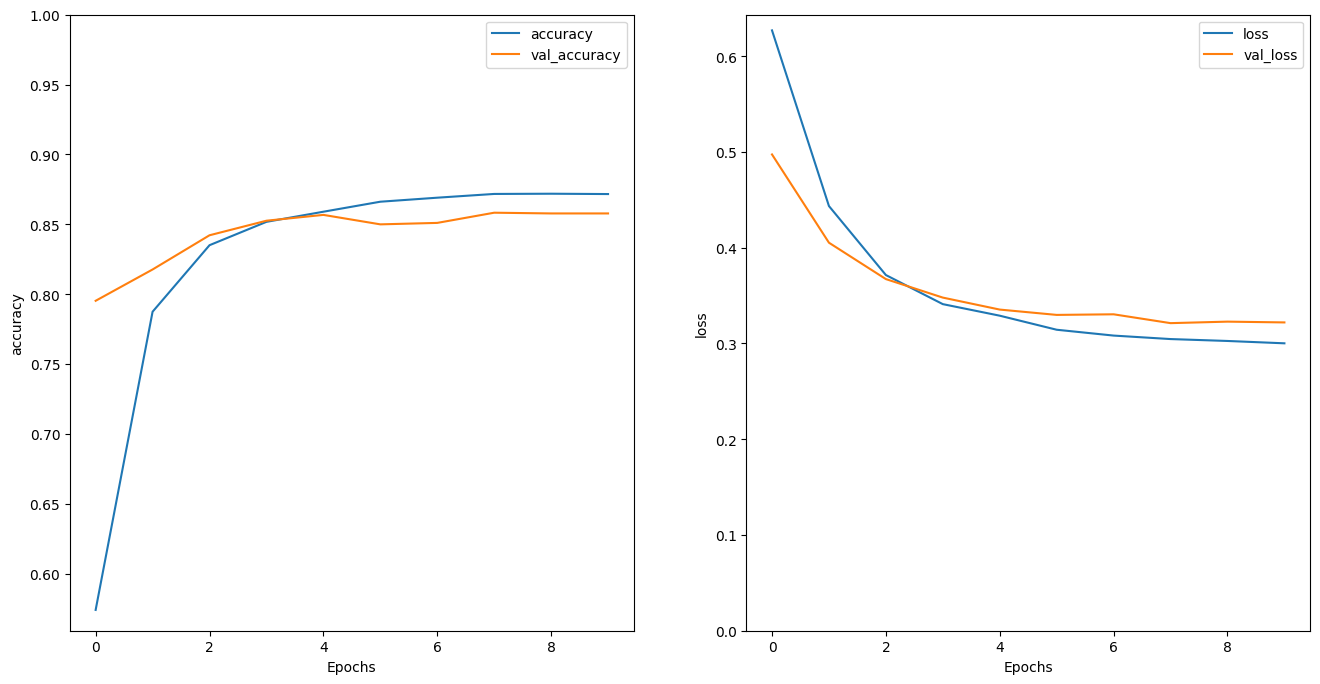

In [20]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [21]:
# Jika prediksi >= 0,0 berarti positif, jika tidak maka negatif

sample_text = ('The movie was cool. The animation and the graphics '
              'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))

1/1 [==============================] - 3s 3s/step


In [22]:
# Stack two or more LSTM layers

model = tf.keras.Sequential([
  encoder,
  tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(1)
])

In [24]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
       optimizer=tf.keras.optimizers.Adam(1e-4),
       metrics=['accuracy'])

In [25]:
history = model.fit(train_dataset, epochs=10,
          validation_data=test_dataset,
          validation_steps=30)

Epoch 1/10
391/391 [==============================] - 81s 158ms/step - loss: 0.6083 - accuracy: 0.6130 - val_loss: 0.4324 - val_accuracy: 0.7969
Epoch 2/10
391/391 [==============================] - 50s 125ms/step - loss: 0.3946 - accuracy: 0.8258 - val_loss: 0.3597 - val_accuracy: 0.8484
Epoch 3/10
391/391 [==============================] - 47s 119ms/step - loss: 0.3466 - accuracy: 0.8520 - val_loss: 0.3448 - val_accuracy: 0.8573
Epoch 4/10
391/391 [==============================] - 48s 122ms/step - loss: 0.3271 - accuracy: 0.8601 - val_loss: 0.3247 - val_accuracy: 0.8526
Epoch 5/10
391/391 [==============================] - 48s 121ms/step - loss: 0.3163 - accuracy: 0.8650 - val_loss: 0.3314 - val_accuracy: 0.8401
Epoch 6/10
391/391 [==============================] - 49s 125ms/step - loss: 0.3122 - accuracy: 0.8677 - val_loss: 0.3220 - val_accuracy: 0.8526
Epoch 7/10
391/391 [==============================] - 49s 124ms/step - loss: 0.3076 - accuracy: 0.8694 - val_loss: 0.3171 - val_ac

In [26]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 22s 55ms/step - loss: 0.3254 - accuracy: 0.8647
Test Loss: 0.32539477944374084
Test Accuracy: 0.8646799921989441


In [27]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics '
              'were terrible. I would not recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions)

1/1 [==============================] - 7s 7s/step
[[-1.6775137]]


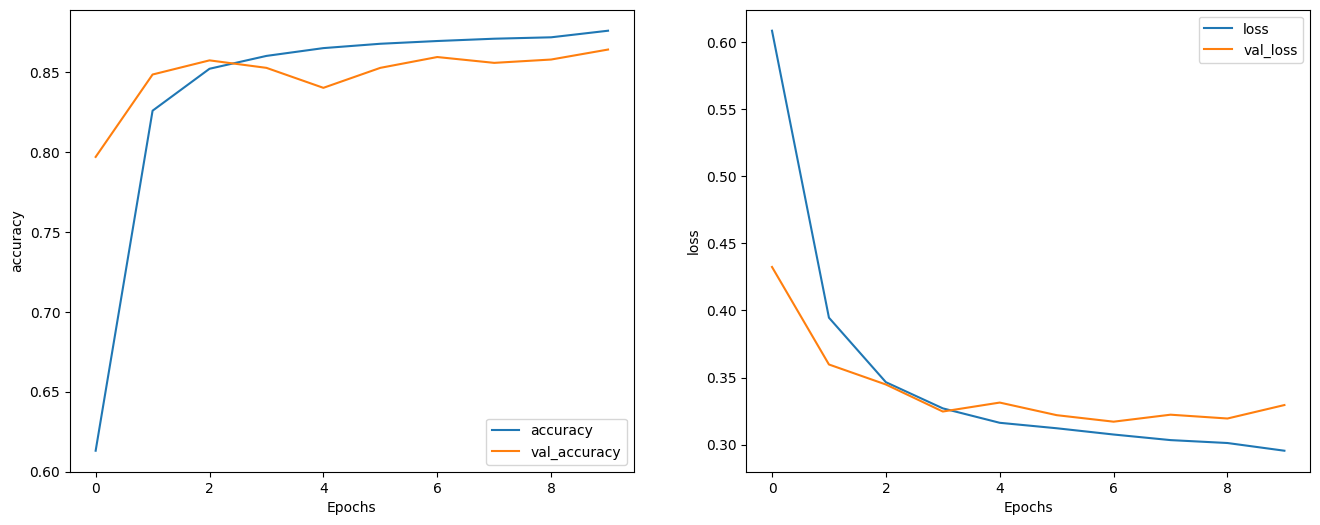

In [28]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

**Praktikum 2**

Generator Teks dengan RNN

In [29]:
# Setup
# Import TensorFlow

import tensorflow as tf
import numpy as np
import os
import time

In [32]:
# Download Dataset Shakespeare

path_to_file = tf.keras.utils.get_file('shakespeare.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt')

1115394/1115394 [==============================] - 1s 1us/step


In [33]:
# Load data

# Read, then decode for py2 compat.
text = open(path_to_file, 'rb').read().decode(encoding='utf-8')
# length of text is the number of characters in it
print(f'Length of text: {len(text)} characters')

Length of text: 1115394 characters


In [34]:
# Take a look at the first 250 characters in text
print(text[:250])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.



In [35]:
# The unique characters in the file
vocab = sorted(set(text))
print(f'{len(vocab)} unique characters')

65 unique characters


In [36]:
# Olah Teks

# Vectorize Teks
example_texts = ['abcdefg', 'xyz']
chars = tf.strings.unicode_split(example_texts, input_encoding='UTF-8')
chars

<tf.RaggedTensor [[b'a', b'b', b'c', b'd', b'e', b'f', b'g'], [b'x', b'y', b'z']]>

In [37]:
ids_from_chars = tf.keras.layers.StringLookup(vocabulary=list(vocab), mask_token=None)

In [38]:
ids = ids_from_chars(chars)
ids

<tf.RaggedTensor [[40, 41, 42, 43, 44, 45, 46], [63, 64, 65]]>

In [39]:
chars_from_ids = tf.keras.layers.StringLookup(
    vocabulary=ids_from_chars.get_vocabulary(), invert=True, mask_token=None)

In [40]:
chars = chars_from_ids(ids)
chars

<tf.RaggedTensor [[b'a', b'b', b'c', b'd', b'e', b'f', b'g'], [b'x', b'y', b'z']]>

In [41]:
tf.strings.reduce_join(chars, axis=-1).numpy()

array([b'abcdefg', b'xyz'], dtype=object)

In [42]:
def text_from_ids(ids):
    return tf.strings.reduce_join(chars_from_ids(ids), axis=-1)

In [43]:
# Prediksi

# Membuat Training Set dan Target
all_ids = ids_from_chars(tf.strings.unicode_split(text, 'UTF-8'))
all_ids

<tf.Tensor: shape=(1115394,), dtype=int64, numpy=array([19, 48, 57, ..., 46,  9,  1])>

In [44]:
ids_dataset = tf.data.Dataset.from_tensor_slices(all_ids)

In [45]:
for ids in ids_dataset.take(10):
    print(chars_from_ids(ids).numpy().decode('utf-8'))

F
i
r
s
t
 
C
i
t
i


In [47]:
seq_length = 100

In [48]:
sequences = ids_dataset.batch(seq_length+1, drop_remainder=True)

for seq in sequences.take(1):
  print(chars_from_ids(seq))

tf.Tensor(
[b'F' b'i' b'r' b's' b't' b' ' b'C' b'i' b't' b'i' b'z' b'e' b'n' b':'
 b'\n' b'B' b'e' b'f' b'o' b'r' b'e' b' ' b'w' b'e' b' ' b'p' b'r' b'o'
 b'c' b'e' b'e' b'd' b' ' b'a' b'n' b'y' b' ' b'f' b'u' b'r' b't' b'h'
 b'e' b'r' b',' b' ' b'h' b'e' b'a' b'r' b' ' b'm' b'e' b' ' b's' b'p'
 b'e' b'a' b'k' b'.' b'\n' b'\n' b'A' b'l' b'l' b':' b'\n' b'S' b'p' b'e'
 b'a' b'k' b',' b' ' b's' b'p' b'e' b'a' b'k' b'.' b'\n' b'\n' b'F' b'i'
 b'r' b's' b't' b' ' b'C' b'i' b't' b'i' b'z' b'e' b'n' b':' b'\n' b'Y'
 b'o' b'u' b' '], shape=(101,), dtype=string)


In [49]:
for seq in sequences.take(5):
    print(text_from_ids(seq).numpy())

b'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '
b'are all resolved rather to die than to famish?\n\nAll:\nResolved. resolved.\n\nFirst Citizen:\nFirst, you k'
b"now Caius Marcius is chief enemy to the people.\n\nAll:\nWe know't, we know't.\n\nFirst Citizen:\nLet us ki"
b"ll him, and we'll have corn at our own price.\nIs't a verdict?\n\nAll:\nNo more talking on't; let it be d"
b'one: away, away!\n\nSecond Citizen:\nOne word, good citizens.\n\nFirst Citizen:\nWe are accounted poor citi'


In [50]:
def split_input_target(sequence):
    input_text = sequence[:-1]
    target_text = sequence[1:]
    return input_text, target_text

In [51]:
split_input_target(list("Tensorflow"))

(['T', 'e', 'n', 's', 'o', 'r', 'f', 'l', 'o'],
 ['e', 'n', 's', 'o', 'r', 'f', 'l', 'o', 'w'])

In [52]:
dataset = sequences.map(split_input_target)

In [53]:
for input_example, target_example in dataset.take(1):
    print("Input :", text_from_ids(input_example).numpy())
    print("Target:", text_from_ids(target_example).numpy())

Input : b'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou'
Target: b'irst Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '


In [55]:
# Membuat Batch Training

# Batch size
BATCH_SIZE = 64

# Buffer size to shuffle the dataset
# (TF data is designed to work with possibly infinite sequences,
# so it doesn't attempt to shuffle the entire sequence in memory. Instead,
# it maintains a buffer in which it shuffles elements).
BUFFER_SIZE = 10000

dataset = (
    dataset
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE))

dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(64, 100), dtype=tf.int64, name=None), TensorSpec(shape=(64, 100), dtype=tf.int64, name=None))>

In [56]:
# Buat Model

# Length of the vocabulary in StringLookup Layer
vocab_size = len(ids_from_chars.get_vocabulary())

# The embedding dimension
embedding_dim = 256

# Number of RNN units
rnn_units = 1024

In [57]:
class MyModel(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, rnn_units):
    super().__init__(self)
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(rnn_units,
                                   return_sequences=True,
                                   return_state=True)
    self.dense = tf.keras.layers.Dense(vocab_size)

  def call(self, inputs, states=None, return_state=False, training=False):
    x = inputs
    x = self.embedding(x, training=training)
    if states is None:
      states = self.gru.get_initial_state(x)
    x, states = self.gru(x, initial_state=states, training=training)
    x = self.dense(x, training=training)

    if return_state:
      return x, states
    else:
      return x

In [58]:
model = MyModel(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    rnn_units=rnn_units)

In [59]:
# Uji Model

for input_example_batch, target_example_batch in dataset.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(64, 100, 66) # (batch_size, sequence_length, vocab_size)


In [60]:
model.summary()

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     multiple                  16896     
                                                                 
 gru (GRU)                   multiple                  3938304   
                                                                 
 dense_4 (Dense)             multiple                  67650     
                                                                 
Total params: 4022850 (15.35 MB)
Trainable params: 4022850 (15.35 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [64]:
sampled_indices = tf.random.categorical(example_batch_predictions[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices, axis=-1).numpy()

sampled_indices

array([30, 13, 52, 10, 32, 32, 17,  0, 42, 41, 37,  4, 11,  3, 28, 30,  3,
        8, 61, 52, 48, 58, 58,  1, 33, 27, 10, 55, 49, 21, 52,  8, 32, 27,
       12, 59, 24, 33, 30, 56, 40, 25, 11,  9, 24, 26, 20, 43, 16, 25, 56,
       22, 39, 14, 18, 24, 56, 30, 64, 17,  0, 31, 10, 12, 35, 64,  5, 26,
       35, 61, 43, 65, 28,  3, 17, 33, 59,  0, 39, 20, 49, 58, 18,  8, 16,
       64, 56, 44, 29, 33, 20, 23, 36, 49, 62,  2, 27,  1, 45,  2])

In [65]:
print("Input:\n", text_from_ids(input_example_batch[0]).numpy())
print()
print("Next Char Predictions:\n", text_from_ids(sampled_indices).numpy())

Input:
 b' eyes: what\neye but such an eye would spy out such a quarrel?\nThy head is as fun of quarrels as an e'

Next Char Predictions:
 b'Q?m3SSD[UNK]cbX$:!OQ!-vmiss\nTN3pjHm-SN;tKTQqaL:.KMGdCLqIZAEKqQyD[UNK]R3;Vy&MVvdzO!DTt[UNK]ZGjsE-CyqePTGJWjw N\nf '


In [66]:
# Train Model

# Tambahan optimizer dan fungsi loss
loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)

example_batch_mean_loss = loss(target_example_batch, example_batch_predictions)
print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("Mean loss:        ", example_batch_mean_loss)

Prediction shape:  (64, 100, 66)  # (batch_size, sequence_length, vocab_size)
Mean loss:         tf.Tensor(4.189268, shape=(), dtype=float32)


In [67]:
tf.exp(example_batch_mean_loss).numpy()

model.compile(optimizer='adam', loss=loss)

In [68]:
# Konfigurasi Checkpoints

# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

In [69]:
# Lakukan Proses Training

EPOCHS = 20

history = model.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_callback])

Epoch 1/20
172/172 [==============================] - 15s 63ms/step - loss: 2.6813
Epoch 2/20
172/172 [==============================] - 12s 62ms/step - loss: 1.9624
Epoch 3/20
172/172 [==============================] - 12s 61ms/step - loss: 1.6840
Epoch 4/20
172/172 [==============================] - 12s 61ms/step - loss: 1.5286
Epoch 5/20
172/172 [==============================] - 12s 61ms/step - loss: 1.4345
Epoch 6/20
172/172 [==============================] - 12s 60ms/step - loss: 1.3678
Epoch 7/20
172/172 [==============================] - 12s 60ms/step - loss: 1.3156
Epoch 8/20
172/172 [==============================] - 12s 60ms/step - loss: 1.2715
Epoch 9/20
172/172 [==============================] - 12s 61ms/step - loss: 1.2301
Epoch 10/20
172/172 [==============================] - 12s 61ms/step - loss: 1.1899
Epoch 11/20
172/172 [==============================] - 12s 60ms/step - loss: 1.1495
Epoch 12/20
172/172 [==============================] - 12s 60ms/step - loss: 1.1067
E

In [70]:
# Generate Teks

class OneStep(tf.keras.Model):
  def __init__(self, model, chars_from_ids, ids_from_chars, temperature=1.0):
    super().__init__()
    self.temperature = temperature
    self.model = model
    self.chars_from_ids = chars_from_ids
    self.ids_from_chars = ids_from_chars

    # Create a mask to prevent "[UNK]" from being generated.
    skip_ids = self.ids_from_chars(['[UNK]'])[:, None]
    sparse_mask = tf.SparseTensor(
        # Put a -inf at each bad index.
        values=[-float('inf')]*len(skip_ids),
        indices=skip_ids,
        # Match the shape to the vocabulary
        dense_shape=[len(ids_from_chars.get_vocabulary())])
    self.prediction_mask = tf.sparse.to_dense(sparse_mask)

  @tf.function
  def generate_one_step(self, inputs, states=None):
    # Convert strings to token IDs.
    input_chars = tf.strings.unicode_split(inputs, 'UTF-8')
    input_ids = self.ids_from_chars(input_chars).to_tensor()

    # Run the model.
    # predicted_logits.shape is [batch, char, next_char_logits]
    predicted_logits, states = self.model(inputs=input_ids, states=states,
                                          return_state=True)
    # Only use the last prediction.
    predicted_logits = predicted_logits[:, -1, :]
    predicted_logits = predicted_logits/self.temperature
    # Apply the prediction mask: prevent "[UNK]" from being generated.
    predicted_logits = predicted_logits + self.prediction_mask

    # Sample the output logits to generate token IDs.
    predicted_ids = tf.random.categorical(predicted_logits, num_samples=1)
    predicted_ids = tf.squeeze(predicted_ids, axis=-1)

    # Convert from token ids to characters
    predicted_chars = self.chars_from_ids(predicted_ids)

    # Return the characters and model state.
    return predicted_chars, states

In [71]:
one_step_model = OneStep(model, chars_from_ids, ids_from_chars)

In [72]:
start = time.time()
states = None
next_char = tf.constant(['ROMEO:'])
result = [next_char]

for n in range(1000):
  next_char, states = one_step_model.generate_one_step(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result[0].numpy().decode('utf-8'), '\n\n' + '_'*80)
print('\nRun time:', end - start)

ROMEO:
The time scarcely seem us to our graves.
O, but he's side my lord I'll make few
To the fear tome men of war, was supposed remorse:
Let me be punish and Marcius is cheeked a
love should end a foolish keal: have you so ask?

Second Watchman:
A murrain's thun; and orper, call'd 'stay; For God he knows, Camillo;
Tremble doom,--if you will take green England.

NORTHUMBERLAND:
His plainly keep thousand men, which we
denied but me and undertake to law aside.

QUEEN MARGARET:
Hold it doth, that yet remains,
This quench the angels whore that was more gasp,
Like death, or suffering by the christs; a very
deceiving him.

Citizens:
I know not what with satisfaction canst thou flat?

BUCKINGHAM:
My Lord of George and oxicoces be his sight!
What wish! what think'st thou?
He will hear him, and old contrarected
stumbled, where and nothing elses here the
bowl, sir, was sudden from the earldom of mine eye
Than fortune bills, for prefured to the full and safety.
'Se indexerate prevake gone. Is thi

In [73]:
start = time.time()
states = None
next_char = tf.constant(['ROMEO:', 'ROMEO:', 'ROMEO:', 'ROMEO:', 'ROMEO:'])
result = [next_char]

for n in range(1000):
  next_char, states = one_step_model.generate_one_step(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result, '\n\n' + '_'*80)
print('\nRun time:', end - start)

tf.Tensor(
[b"ROMEO:\nThe becomies sigh of them very closely particulary,\nOn pain of death terror Brangot.\n\nLEONTES:\nI'll not to her: Kate, and so, sir; for\nwithin this night, we do importune\nhonesty--on the Admoder, as our good shadows.\n\nWARWICK:\nSo shall we tell where have you like perpetual.\n\nLUCIO:\nNot as a drunk; therefore if you be, her brother\nBlue cast thy curses through a travelly.\n\nWARWICK:\nAy, but they say, ask it elsewhere.\n\nPAULINA:\nIndeed, my lords,\nLook, sir! what said Mortion, obey?\nWhat is it that I daunt his enouncain issue,\nAs, what you ha, though you have said,\nBecause his natural slaves thy name,\nOr water and creditom sorn them time;\nWhere shall we see him, was his holidate,\nAnd fightful frign, our nearness to me on;\nAnd turn'd mine eyes to be Luceetingain,\nWhat sayest thou? is that so stead of war\nTruer love and frant-cooken fingers are may.\nGo bear this present dear for't: give\nthe gods, all sees all night, and tears garment for Ric

In [74]:
# Ekspor Model Generator

tf.saved_model.save(one_step_model, 'one_step')
one_step_reloaded = tf.saved_model.load('one_step')

In [75]:
states = None
next_char = tf.constant(['ROMEO:'])
result = [next_char]

for n in range(100):
  next_char, states = one_step_reloaded.generate_one_step(next_char, states=states)
  result.append(next_char)

print(tf.strings.join(result)[0].numpy().decode("utf-8"))

ROMEO:
That's to sayn.

PAULINA:
To the place esteem up him there:
Then am I kins from grief but honest wa


# Tugas Praktikum

1. Jalankan Model dan hitung loss dengan tf.GradientTape.
2. Hitung update dan terapkan pada model dengan optimizer

Jawab

In [76]:
class CustomTraining(MyModel):
 @tf.function
 def train_step(self, inputs):
   inputs, labels = inputs
   with tf.GradientTape() as tape:
     predictions = self(inputs, training=True)
     loss = self.loss(labels, predictions)
   grads = tape.gradient(loss, model.trainable_variables)
   self.optimizer.apply_gradients(zip(grads, model.trainable_variables))

   return {'loss': loss}

In [77]:
model = CustomTraining(
  vocab_size=len(ids_from_chars.get_vocabulary()),
  embedding_dim=embedding_dim,
  rnn_units=rnn_units)

In [78]:
model.compile(optimizer = tf.keras.optimizers.Adam(),
       loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True))

In [79]:
model.fit(dataset, epochs=1)

172/172 [==============================] - 15s 53ms/step - loss: 2.7160


Atau jika ingin lebih mengetahui dalamnya, kita bisa membuat custom training loop sendiri:

In [80]:
EPOCHS = 10

mean = tf.metrics.Mean()

for epoch in range(EPOCHS):
  start = time.time()

  mean.reset_states()
  for (batch_n, (inp, target)) in enumerate(dataset):
    logs = model.train_step([inp, target])
    mean.update_state(logs['loss'])

    if batch_n % 50 == 0:
      template = f"Epoch {epoch+1} Batch {batch_n} Loss {logs['loss']:.4f}"
      print(template)

# saving (checkpoint) the model every 5 epochs
  if (epoch + 1) % 5 == 0:
   model.save_weights(checkpoint_prefix.format(epoch=epoch))

print()
print(f'Epoch {epoch+1} Loss: {mean.result().numpy():.4f}')
print(f'Time taken for 1 epoch {time.time() - start:.2f} sec')
print("_"*80)

model.save_weights(checkpoint_prefix.format(epoch=epoch))

Epoch 1 Batch 0 Loss 2.1665
Epoch 1 Batch 50 Loss 2.0271
Epoch 1 Batch 100 Loss 1.9661
Epoch 1 Batch 150 Loss 1.8632
Epoch 2 Batch 0 Loss 1.8623
Epoch 2 Batch 50 Loss 1.7328
Epoch 2 Batch 100 Loss 1.6990
Epoch 2 Batch 150 Loss 1.6270
Epoch 3 Batch 0 Loss 1.6350
Epoch 3 Batch 50 Loss 1.5826
Epoch 3 Batch 100 Loss 1.5552
Epoch 3 Batch 150 Loss 1.4923
Epoch 4 Batch 0 Loss 1.4557
Epoch 4 Batch 50 Loss 1.4962
Epoch 4 Batch 100 Loss 1.4503
Epoch 4 Batch 150 Loss 1.4038
Epoch 5 Batch 0 Loss 1.4095
Epoch 5 Batch 50 Loss 1.3459
Epoch 5 Batch 100 Loss 1.4293
Epoch 5 Batch 150 Loss 1.3542
Epoch 6 Batch 0 Loss 1.3092
Epoch 6 Batch 50 Loss 1.2857
Epoch 6 Batch 100 Loss 1.3070
Epoch 6 Batch 150 Loss 1.3275
Epoch 7 Batch 0 Loss 1.2603
Epoch 7 Batch 50 Loss 1.2507
Epoch 7 Batch 100 Loss 1.2969
Epoch 7 Batch 150 Loss 1.2895
Epoch 8 Batch 0 Loss 1.1972
Epoch 8 Batch 50 Loss 1.2201
Epoch 8 Batch 100 Loss 1.2709
Epoch 8 Batch 150 Loss 1.2398
Epoch 9 Batch 0 Loss 1.1840
Epoch 9 Batch 50 Loss 1.2263
Epoch 9

**Jalankan kode diatas dan sebutkan perbedaanya dengan praktikum 2?**

1. Model: Praktikum 2 menggunakan model RNN, sementara pelatihan tugas menggunakan model yang lebih kompleks, yaitu GRU.
2. Epochs: Praktikum 2 menjalankan model selama 20 epoch, sementara pelatihan tugas hanya selama 10 epoch.
3. Prosedur Pelatihan: Praktikum 2 lebih sederhana karena menggunakan metode bawaan Keras, sedangkan pelatihan tugas melibatkan pengaturan yang lebih kustom dengan train_step.
4. Output Hasil Pelatihan: Praktikum 2 memberikan info singkat tentang loss, sedangkan pelatihan tugas mencantumkan loss untuk setiap batch dan epoch, serta waktu eksekusi.
5. Waktu Eksekusi: Praktikum 2 mungkin lebih cepat karena model sederhana dan 20 epoch, sedangkan pelatihan tugas lebih lama karena 10 epoch dan mungkin model yang lebih rumit.